<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/mini_labs/week_11_ensembles.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# BYU CS 473 — Basics of Ensemble Learning

In this assignment, you will learn the foundations of **ensemble learning**.

We will explore **bagging, boosting, and stacking**, visualize their behavior, and clarify how ensemble methods differ from Bayesian model averaging.

---

## Learning Goals
- Understand the motivation for ensemble methods  
- Compare bagging, boosting, and stacking  
- Visualize how ensembles reduce error or improve generalization  
- Clarify the distinction between ensembles and Bayesian model averaging  


## 1. Ensemble Learning

- **Definition**: Ensemble methods combine multiple "weak" or "base" learners into a stronger model.  
- **Motivation**: A single model may be unstable or biased, but a combination can reduce error.  

Analogy: "A crowd of diverse opinions can often outperform a single expert."

### Exercise 1
Give an example (real-life or in ML) where combining multiple perspectives leads to a better decision than relying on a single one.


There's a famous experiment where a large group of people were asked how many gumballs were in a jar. While the answers varied greatly in range, their average was near-perfect.

## 2. Bagging

- **Key idea**: Train multiple models on different **bootstrap samples** (random samples with replacement) and average their predictions.  
- **Effect**: Reduces variance by averaging over noisy models.  
- **Example**: Random Forest (bagging applied to decision trees).


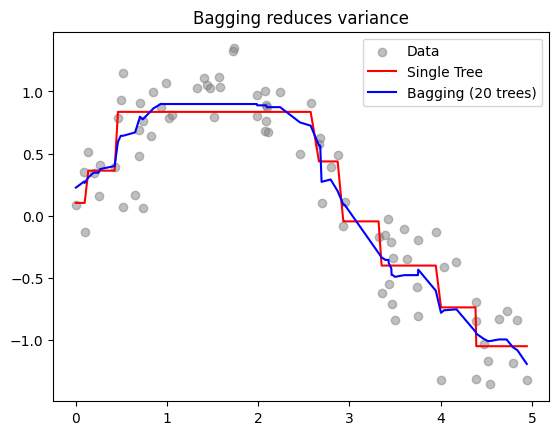

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

# Generate noisy data
np.random.seed(1)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.3, X.shape[0])

# Single tree
tree = DecisionTreeRegressor(max_depth=3).fit(X, y)

# Bagging: average of many trees trained on bootstraps
preds = []
for i in range(20):
    sample_idx = np.random.choice(len(X), len(X), replace=True)
    Xi, yi = X[sample_idx], y[sample_idx]
    model = DecisionTreeRegressor(max_depth=3).fit(Xi, yi)
    preds.append(model.predict(X))
bagged_pred = np.mean(preds, axis=0)

# Plot
plt.scatter(X, y, c="gray", label="Data", alpha=0.5)
plt.plot(X, tree.predict(X), label="Single Tree", color="red")
plt.plot(X, bagged_pred, label="Bagging (20 trees)", color="blue")
plt.legend()
plt.title("Bagging reduces variance")
plt.show()


### Exercise 2
Why does bagging reduce variance but not bias?  


Bagging attacks variance because it reduces the sensitivity of the model to particular training samples, but bias comes from model limitations, and bagging doesn’t change the model class; it only changes which data each specific model sees.

An analogy that I found and like is "Imagine estimating the weight of a car using a bathroom scale that maxes out at 300 lbs. Everyone who tries gets '300 lbs,' and averaging all their answers still gives '300 lbs,' despite the car clearly weighing far beyond that. The scale is biased by its upper limit, and averaging biased measurements does not fix the underlying limitation."

## 3. Boosting

- **Key idea**: Train models **sequentially**, where each new model focuses on the errors (residuals) of the previous ones.  
- **Effect**: Reduces bias by making weak learners stronger.  
- **Examples**: AdaBoost, Gradient Boosting, **XGBoost**.


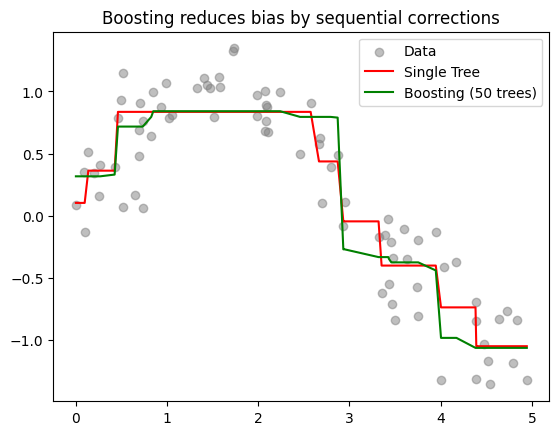

In [2]:
from sklearn.ensemble import AdaBoostRegressor

# Boosting model
boost = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=2), n_estimators=50, random_state=1
).fit(X, y)

plt.scatter(X, y, c="gray", alpha=0.5, label="Data")
plt.plot(X, tree.predict(X), label="Single Tree", color="red")
plt.plot(X, boost.predict(X), label="Boosting (50 trees)", color="green")
plt.legend()
plt.title("Boosting reduces bias by sequential corrections")
plt.show()


### Exercise 3
- How is boosting different from bagging in the way it trains its models?  
- Which type of error (bias vs variance) does boosting primarily address?  


In Boosting, each new model learns from the mistakes of the earlier ones. Bagging reduces noise by averaging many independently trained models.
It's the difference between one student warning another student about tricky questions on a test and a group of students averaging their test scores with each other.

Boosting reduces primarily bias, by correcting its errors step by step and adding layers of refinement.

## 4. Stacking

- **Key idea**: Train different kinds of models, then use a **meta-model** to combine their predictions.  
- **Effect**: Learns the best way to weigh/merge multiple predictors.  


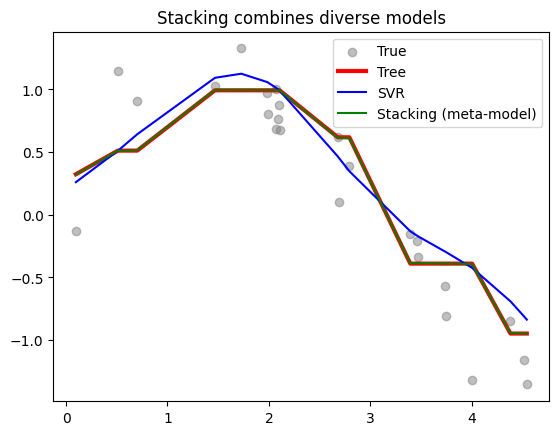

[0.97886815 0.0224603 ]


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Base models
model1 = DecisionTreeRegressor(max_depth=3).fit(X_train, y_train)
model2 = SVR(kernel="rbf", C=10).fit(X_train, y_train)

# Predictions from base models
pred_train = np.vstack([model1.predict(X_train), model2.predict(X_train)]).T
pred_test = np.vstack([model1.predict(X_test), model2.predict(X_test)]).T

# Meta-model
meta = LinearRegression().fit(pred_train, y_train)

plt.scatter(X_test, y_test, c="gray", label="True", alpha=0.5)

sorted_idx = np.argsort(X_test[:, 0])
X_sorted = X_test[sorted_idx]

y_tree = model1.predict(X_test)[sorted_idx]
y_svr = model2.predict(X_test)[sorted_idx]
y_stack = meta.predict(pred_test)[sorted_idx]

plt.plot(X_sorted, y_tree, color="red", linewidth=3, label="Tree")
plt.plot(X_sorted, y_svr, color="blue", label="SVR")
plt.plot(X_sorted, y_stack, color="green", label="Stacking (meta-model)")
plt.legend()
plt.title("Stacking combines diverse models")
plt.show()

# This shows us how much the [Tree, SVR] effects the meta model. Why do you think Tree is so much more effective?
print(meta.coef_)


### Exercise 4
Why might stacking outperform both bagging and boosting on some datasets?  

Stacking leverages model diversity and a learned combination strategy, giving it flexibility that bagging and boosting (which use mostly identical base learners) often lack.

## 5. Important Distinction

Ensemble learning is **not** Bayesian model averaging.

- **Bayesian model averaging (BMA)**: weights models by their posterior probabilities given the data.  
- **Ensembling**: weights (or aggregates) models based on empirical performance, not Bayesian probabilities.  

**Key difference**:  
- Ensembling is a pragmatic, data-driven technique.  
- BMA is a probabilistic inference method.  


## 6. Reflection

### Exercise 6
1. Compare bagging, boosting, and stacking in terms of:
   - Training procedure  
   - Error type reduced (bias vs variance)  
   - Typical use cases  
   
2. If you had a very small dataset, which ensemble method would you avoid, and why?  


Bagging	Models are trained independently in parallel on bootstrap samples (random sampling with replacement).
Boosting Models are trained sequentially, where each new model focuses on errors/residuals from previous ones.
Stacking has different types of models trained independently on the same data, and then a meta-model is trained on their predictions to combine them.

Bagging focuses on reducing variance, reducing overfitting and stabilizing predictions.
Boosting focuses on reducing bias, sequential correction improves underfit models.
Stacking can reduce both bias and variance by leveraging diverse models and learns an optimal combination.

Bagging	is used in high-variance models (e.g., decision trees) or noisy data. Classic example: Random Forest.
Boosting is used for weak learners who underfit the data; it needs to reduce bias. Examples: AdaBoost, Gradient Boosting, XGBoost.
Stacking is used for complex datasets where combining multiple model types can capture diverse patterns.


On very small datasets, bagging is the best of the three options. Boosting can overfit easily, since the model keeps focusing on the few “hard” examples in the tiny dataset. Stacking may also overfit because it has few samples to learn how to weight base models.